# Task 1: Time Series Modeling

Alex Rivera ID#011243153

Western Governors University

D213 - Advanced Data Analytics

December 22, 2023

## A1: Proposal Of Question

The research question for this project is, "Can an autoregressive integrated moving average(ARIMA) model significantly forecast customer daily revenue?"

## A2: Defined Goal

The main objective of this analysis is to implement a predictive autoregressive integrated moving average(ARIMA) model. While implementing the ARIMA model another objective would be analyzing the daily revenue for seasonality, trends, and if it's stationarity. The goal of the analysis is to significantly forecast daily revenue with a mean absolute percentage error of 10% or less. 

## B: Summary Of Assumptions

### Time Series Assumptions

Below a few time series assumptions highlighted by Pandian (Pandian, 2023)

- Dataset should be stationary if not converted into stationary dataset through differencing
- Missing values are not supported by time series analysis
- Data points must have linear relationships

### Stationarity

According to the article by Ravelo, "The assumption of stationary data refers to the idea that the statistical properties of a time series do not change over time. More specifically, a stationary time series is one in which the mean, variance, and autocorrelation structure are constant over time" (Ravelo, 2023). 

### Autocorrelated Data

    Autocorrelation refers to the degree of similarity between A) a given time series, and B) a lagged version of itself, over C) successive time intervals. In other words, autocorrelation is intended to measure the relationship between a variable’s present value and any past values that you may have access to (Anais Dotis-Georgiou, 2023).
## C1: Line Graph Visualization

In [1]:
#Importing necessary packages for the Time Series project 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
import warnings 
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
times = pd.read_csv('C:/Users/alexa/WGU/D213/Project/teleco_time_series.csv')

times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.5 KB


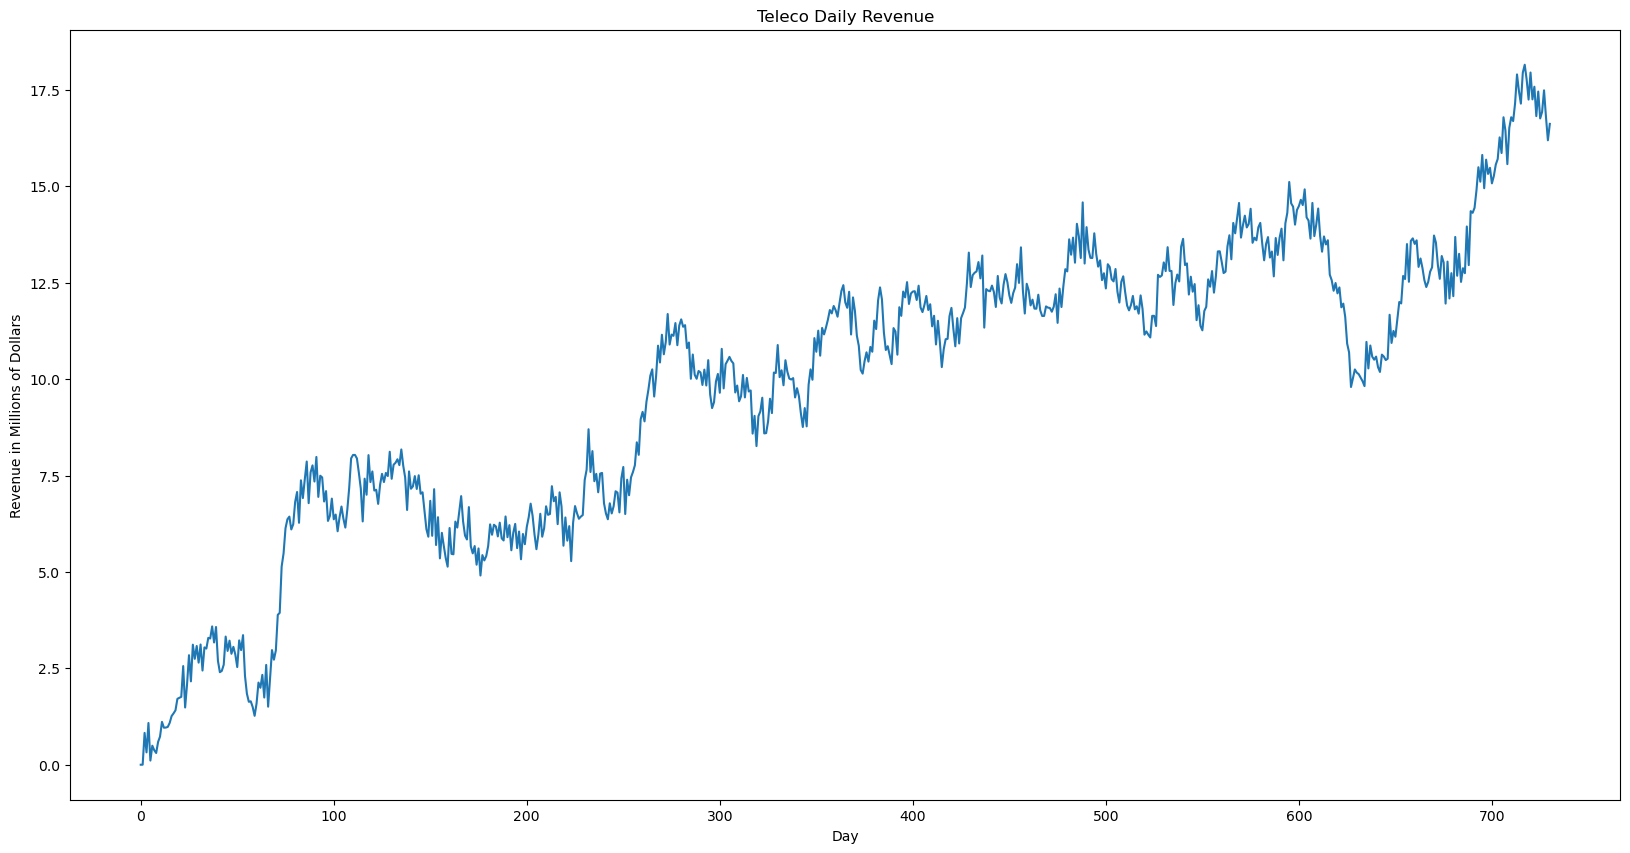

In [3]:
plt.figure(figsize = [20,10])
plt.title('Teleco Daily Revenue')
plt.plot(times['Revenue'])
plt.xlabel('Day')
plt.ylabel('Revenue in Millions of Dollars')
plt.show()

## C2: Time Step Formatting

The time series data was loaded into a dataframe and cross-referenced against the data dictionary expectations. Using info() on the dataframe it consisted of 731 observations and two columns. As expected it matched the data dictionary with a day and revenue columns. The length of the sequence was 731 rows over two years, this led to the conclusion of the dataset starting on the leap year 2020. Verification of any gaps in measurement was checked through the function isnull() and summing the totals found in the dataset, no gaps were present in the dataset. To format the day column, pandas was utilized to implement the to_timedelta() function and with a start date of 2020-01-01, the date was formatted over the 731 rows. The day column was implemented as an index for the data frame. 

In [4]:
times

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554
...,...,...
726,727,16.931559
727,728,17.490666
728,729,16.803638
729,730,16.194813


In [5]:
times.isnull().sum()

Day        0
Revenue    0
dtype: int64

In [6]:
# Video refernced for datetime & timedelta coding below(Ingle, 2020)
x = pd.to_datetime('2020-01-01')
times['Day'] = pd.to_timedelta(times['Day']-1, unit='D') + x
times.set_index('Day', inplace=True)
times

,Revenue
Day,
2020-01-01,0.000000
2020-01-02,0.000793
2020-01-03,0.825542
2020-01-04,0.320332
2020-01-05,1.082554
...,...
2021-12-27,16.931559
2021-12-28,17.490666
2021-12-29,16.803638


## C3: Stationarity

The time series dataset can be visually evaluated for any upward or downward trends, below a trendline included in the daily revenue dataset. Clearly, there is an upward trend on the dataset but this is subjective. Next, the statistical test Augmented Dickey-Fuller (ADF) will be implemented to evaluate the stationarity as presented by the article referenced (Pandian, 2023).

    - Null Hypothesis (H0): Series is non-stationary
    - Alternate Hypothesis (HA): Series is stationary
        - p-value >0.05 Fail to reject (H0)
        - p-value <=0.05 Accept (H1)

The ADF statistic of the dataset was -1.92 and the matching P-Value 0.321. This led to the conclusion that is non-stationary. 

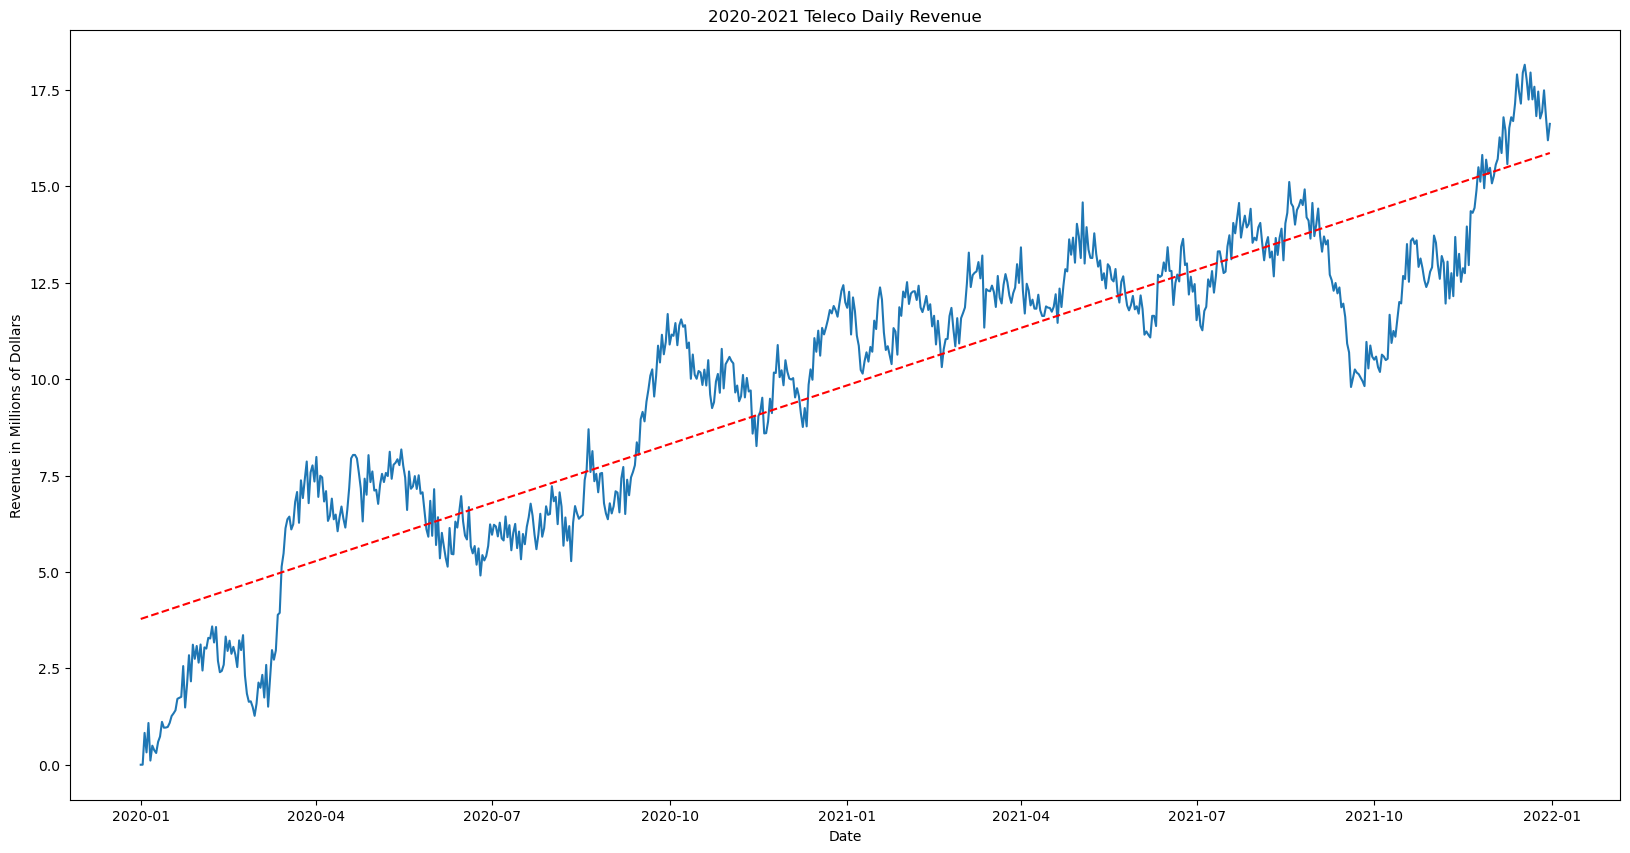

In [7]:
plt.figure(figsize = [20,10])
plt.title('2020-2021 Teleco Daily Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue in Millions of Dollars')
plt.plot(times)
#Article referenced for dates API (Matplotlib.dates#, n. d.)
x = mdates.date2num(times.index)
y = times['Revenue']
#Article referenced for trendline code(Bobbitt, 2022)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), color='r', linestyle="--")
plt.show()

In [8]:
#Article referenced for ADF code(D'Amico, 2023)
adftest = adfuller(times['Revenue'])
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])

ADF-Statistic: -1.9246121573101849
P-Value: 0.3205728150793957


## C4: Steps To Prepare The Data

The first step implemented to prepare the data for the time series analysis is the time step formatting of the dataframe. The day column was formatted and adjusted to the date format starting on 2020-01-01 and ending on 2021-12-31 for the 731 rows. The day column was converted to the index. Professor Sewell's D213 webinar was referred for data preparation steps, now that the dataset was confirmed to be non-stationary it will need to be converted(Sewell, 2023). Differencing was implemented to make the dataset stationary with the following functions diff().dropna(). Augmented Dickey-Fuller code was run again to confirm that the dataset was now stationary with a P-value of 0.0 the dataset is now ready to be split. The training and test sets were split into 80% training and 20% test, shuffle was set to false as the data needed to be kept in order. The test set is 147 rows that will be used for forecasting and model evaluation metrics in later sections of the analysis. 

ADF-Statistic: -44.87452719387599
P-Value: 0.0


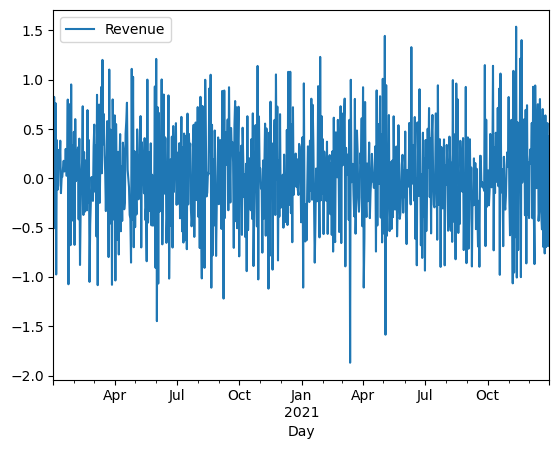

In [9]:
#Article referenced for data preparation (Sewell, 2023)
times_processed = times.diff().dropna()

#Article referenced for ADF code(D'Amico, 2023)
adftest = adfuller(times_processed['Revenue'])
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])

times_processed.plot()
plt.show()

In [10]:
X_train, X_test = train_test_split(times_processed, test_size=0.2, shuffle=False ,random_state=1)

## C5: Prepared Data Set

In [11]:
#Save prepared time series dataset to CSV 
X_train.to_csv('C:/Users/alexa/WGU/D213/Project/Train_Prepared_Data.csv')
X_test.to_csv('C:/Users/alexa/WGU/D213/Project/Test_Prepared_Data.csv')

## D1: Report Findings And Visualizations

### Presence or lack of a seasonal component

Running the seasonal_decompose code on the time series dataset illustrates a seasonality component present. From the start of the time series 2020-01 and 2020-04, it shows roughly a weekly seasonal pattern. 

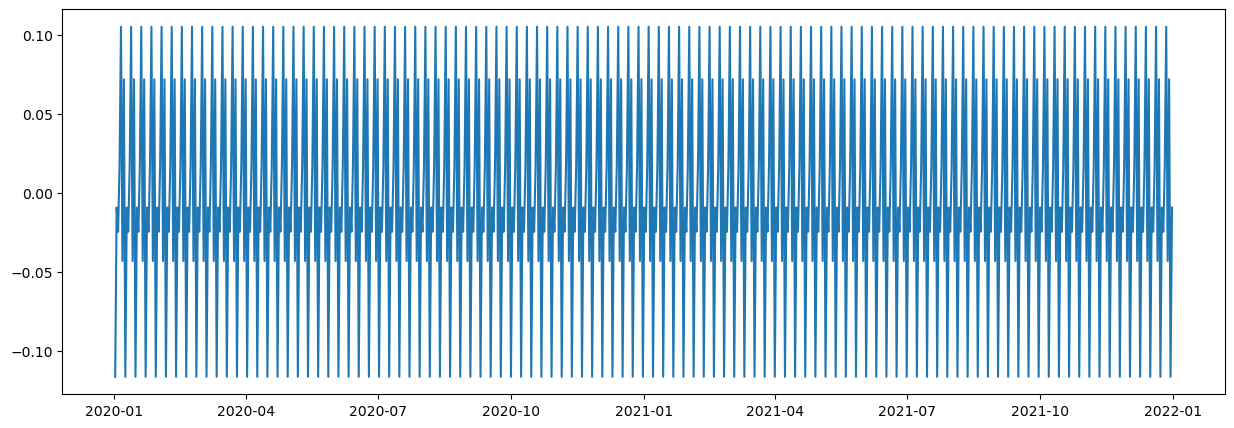

In [12]:
#Article referenced for seasonal_decompose code(Tuychiev, 2023)
times_decomposed = seasonal_decompose(times_processed)
plt.figure(figsize = [15,5])
plt.plot(times_decomposed.seasonal)
plt.show()

### Trends

The output of the trend analysis shows the dataset hovering around 0.0 with no specific upward or downward trend.

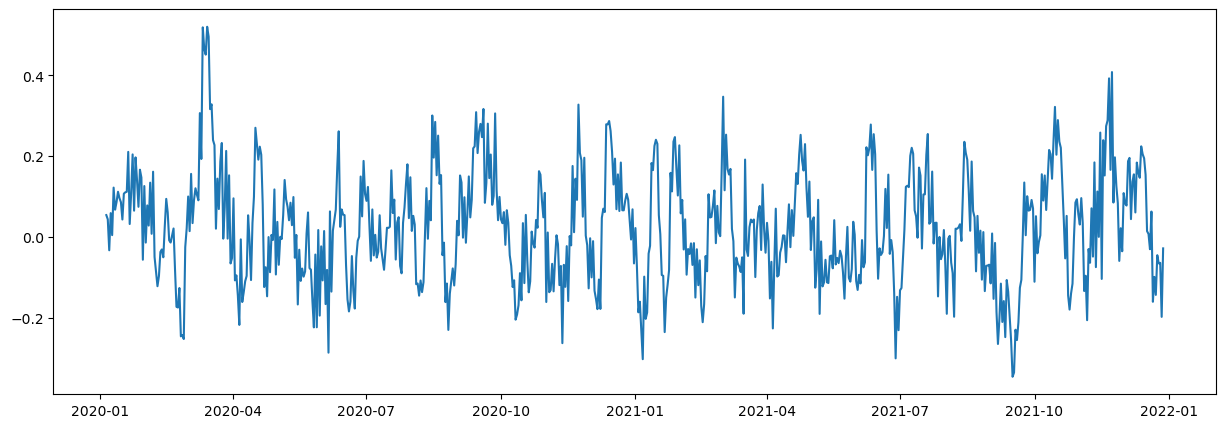

In [13]:
#Article referenced for trends code(Tuychiev, 2023)
plt.figure(figsize = [15,5])
plt.plot(times_decomposed.trend)
plt.show()

### Autocorrelation Function

An interpretation of the ACF and PACF led to the conclusion of AR(1). Ahmed stated, "If the ACF and PACF plots both show spikes at the first few lags, then an ARMA model may be appropriate" (Ahmed, 2023).

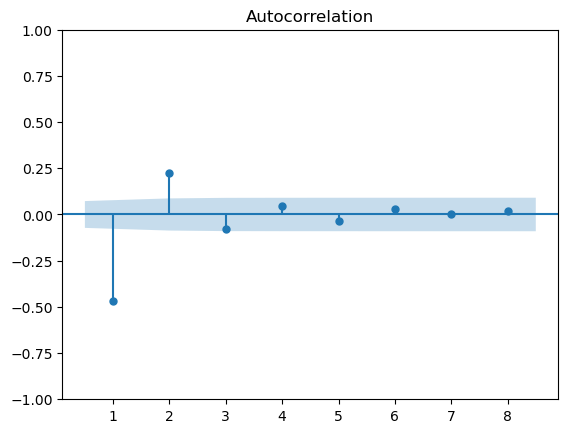

In [14]:
#Article referenced for plot_acf code(Tuychiev, 2023)
acf = plot_acf(times_processed, lags=8, zero=False)

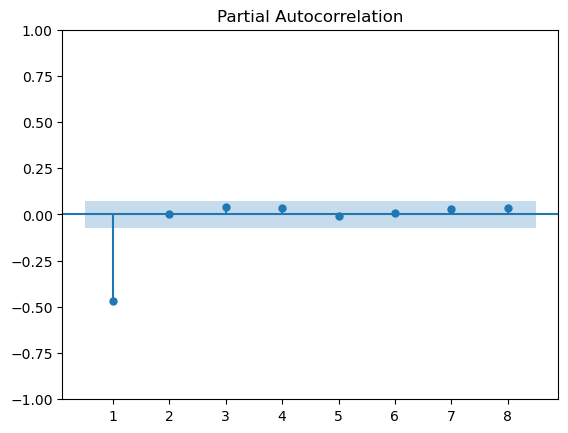

In [15]:
#Article referenced for plot_pacf code(Tuychiev, 2023)
pacf = plot_pacf(times_processed, lags=8, zero=False)

### Spectral Density

Below is the code and visualization of the spectral density time series dataset. 

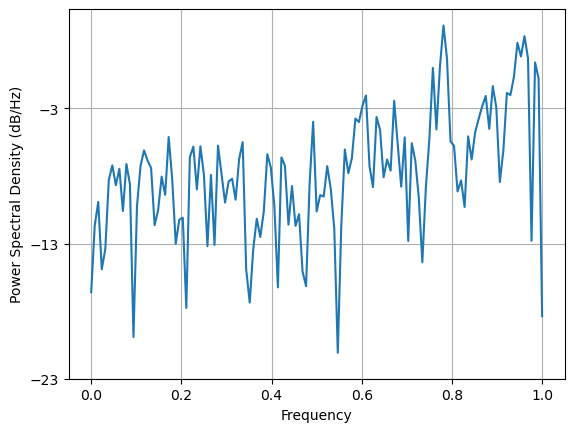

In [16]:
#Article referenced for psd code(Rishi, 2021)
plt.psd(x=times_processed['Revenue'])
plt.show()

### Decomposed Time Series

Below is a visualization of the decomposed time series with the following components: seasonal, trend, and residual.

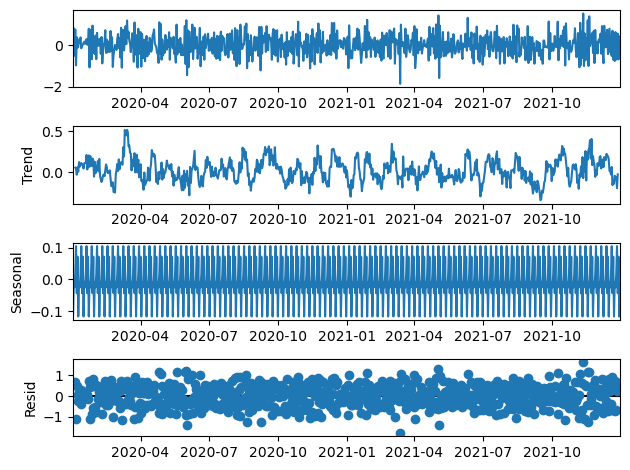

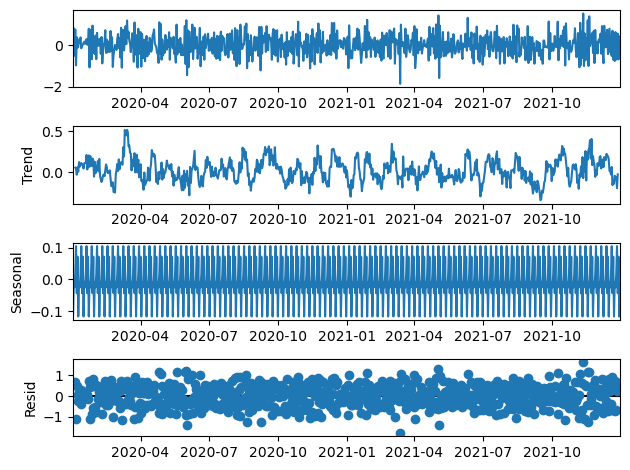

In [17]:
#Article referenced for times_decomposed code(Elleh, 2022)
times_decomposed.plot()

### Confirmation of the lack of trends in the residuals of the decomposed series

The decomposed time series dataset was plotted below with no apparent trends and all data hovering around 0.0. 

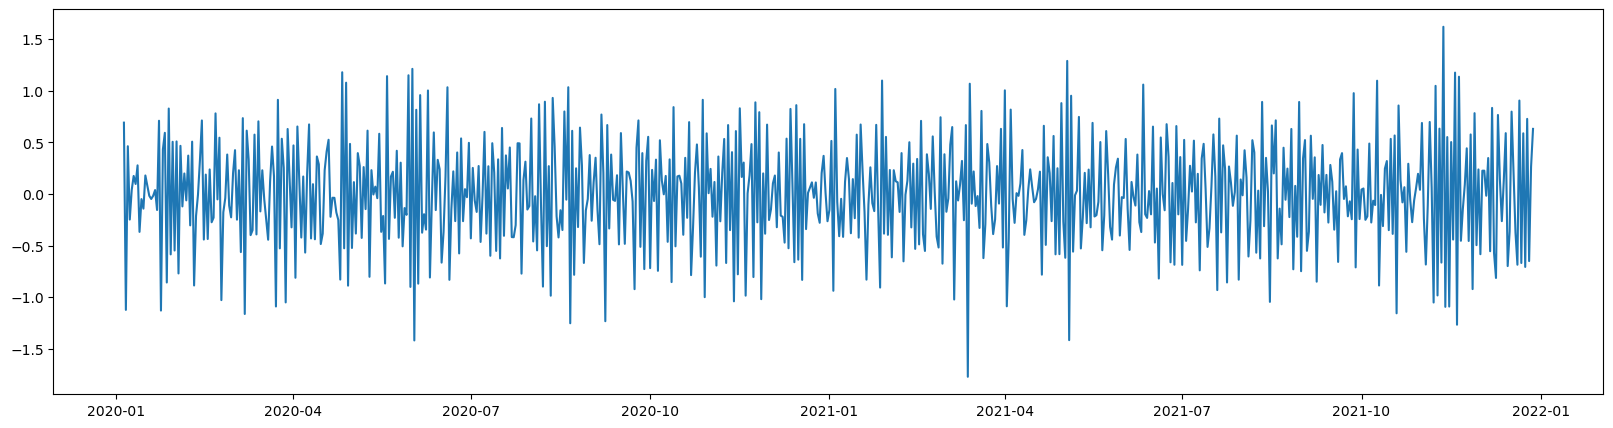

In [18]:
#Article referenced for resid code(Elleh, 2022)
plt.figure(figsize = [20,5])
plt.plot(times_decomposed.resid)
plt.show()

## D2: Arima Model

As identified in section D1 through the autocorrelation function, AR(1) was concluded. To statistically identify the model auto_arima was run on the training data and concluded the same outcome of ARIMA(1,0,0). Once confirmed the ARIMA model was run on the training data and is ready for forecasting.

In [19]:
#Webniar 2 referenced for ARIMA (Sewell, 2023)
auto_fit=auto_arima(X_train["Revenue"],trace=True, suppress_warnings=True)
auto_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=777.983, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=910.790, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=773.893, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=799.464, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=909.948, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=775.886, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=775.888, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=777.694, Time=0.38 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=774.990, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.964 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  584
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -383.946
Date:                Fri, 22 Dec 2023   AIC                            773.893
Time:                        22:50:44   BIC                            787.002
Sample:                    01-02-2020   HQIC                           779.002
                         - 08-07-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0341      0.019      1.751      0.080      -0.004       0.072
ar.L1         -0.4597      0.036    -12.654      0.000      -0.531      -0.388
sigma2         0.2180      0.014     16.034      0.000       0.191       0.245
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.84
Prob(Q):                              0.96   Prob(JB):                         0.40
Heteroskedasticity (H):               0.97   Skew:                            -0.08
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
#Webniar 2 referenced for ARIMA (Sewell, 2023)
model = ARIMA(X_train["Revenue"], order = (1,0,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -383.946
Date:                Fri, 22 Dec 2023   AIC                            773.893
Time:                        22:50:44   BIC                            787.002
Sample:                    01-02-2020   HQIC                           779.002
                         - 08-07-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0234      0.013      1.758      0.079      -0.003       0.049
ar.L1         -0.4597      0.036    -12.654      0.000      -0.531      -0.388
sigma2         0.2180      0.014     16.034      0.000       0.191       0.245
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.84
Prob(Q):                              0.96   Prob(JB):                         0.40
Heteroskedasticity (H):               0.97   Skew:                            -0.08
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## D3: Forecasting Using Arima Model

The forecast was created using the get_prediction function for a 20% amount that matches the test split in section C4, 146 rows of prediction. The projection dataframe was used to predict the mean of the forecast displayed below. The dataframes were cumulative to reserve the differencing and visualize the actual revenue and forecasted portion. 

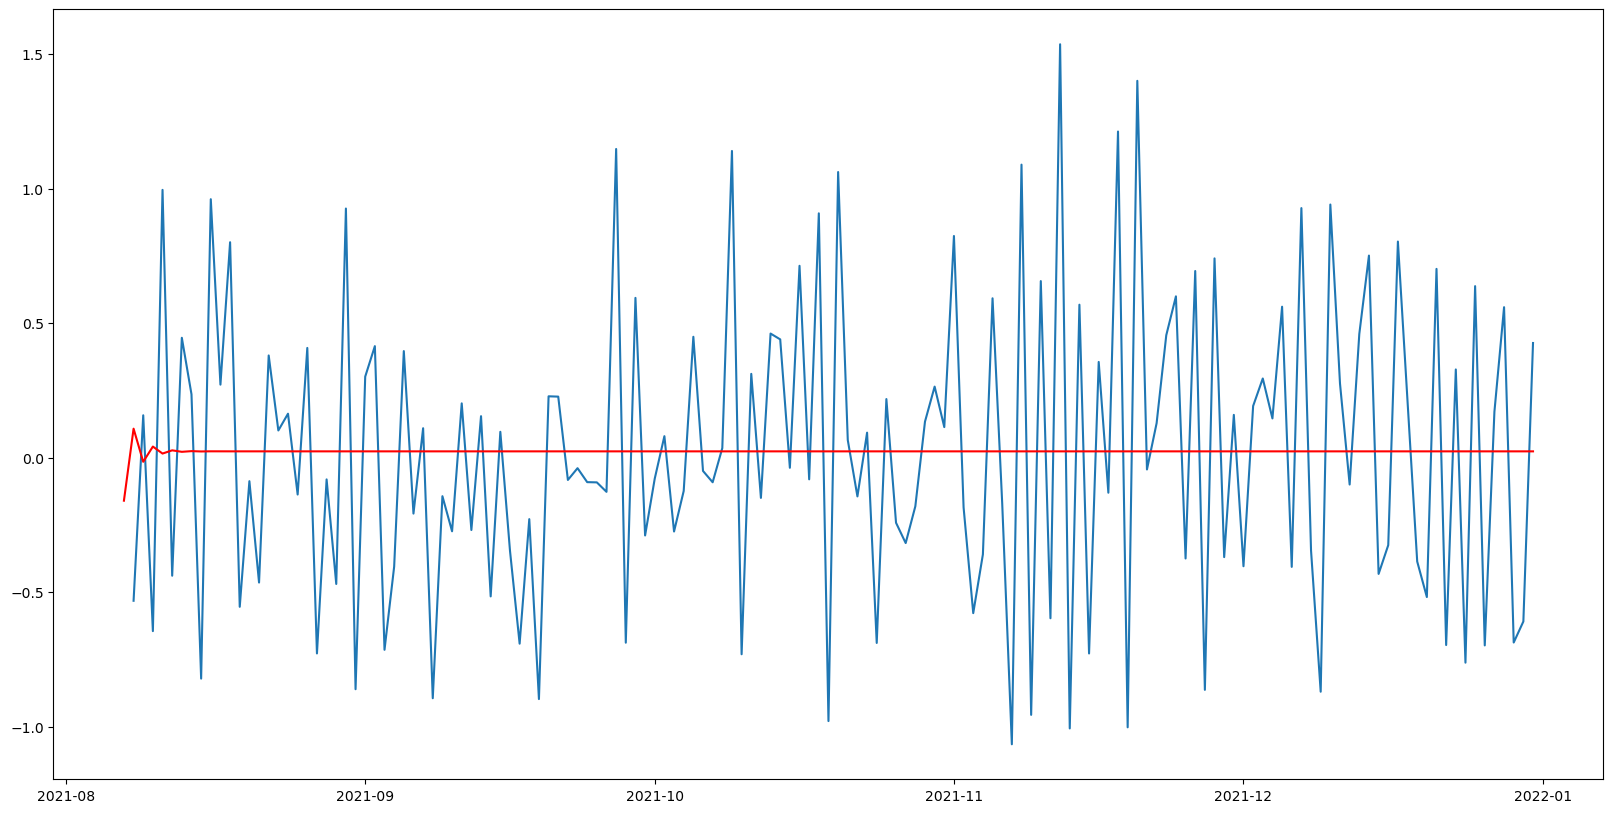

In [21]:
#Article referenced for projection code(Elleh, 2022)
projection = model_fit.get_prediction(start = 583, end = 729, dynamic = True)
predicted_mean = pd.DataFrame(projection.predicted_mean)
predicted_mean = predicted_mean.rename(columns={'predicted_mean' : 'Revenue'})
plt.figure(figsize = [20,10])
plt.plot(X_test)
plt.plot(predicted_mean, color='r')
plt.show()

In [22]:
#Create copies of dataframes needed for forecast
X_train_copy= X_train.copy(deep=True)
predicted_mean_copy= predicted_mean.copy(deep=True)

#Concatenate & cumulative sums to reverse differencing
a_forecast = (pd.concat([X_train_copy, predicted_mean_copy])).cumsum()
a_forecast.loc[:len(X_train), 'Revenue'] = np.nan
a_forecast

,Revenue
2020-01-02,NaN
2020-01-03,NaN
2020-01-04,NaN
2020-01-05,NaN
2020-01-06,NaN
...,...
2021-12-27,16.899070
2021-12-28,16.922426
2021-12-29,16.945782
2021-12-30,16.969137


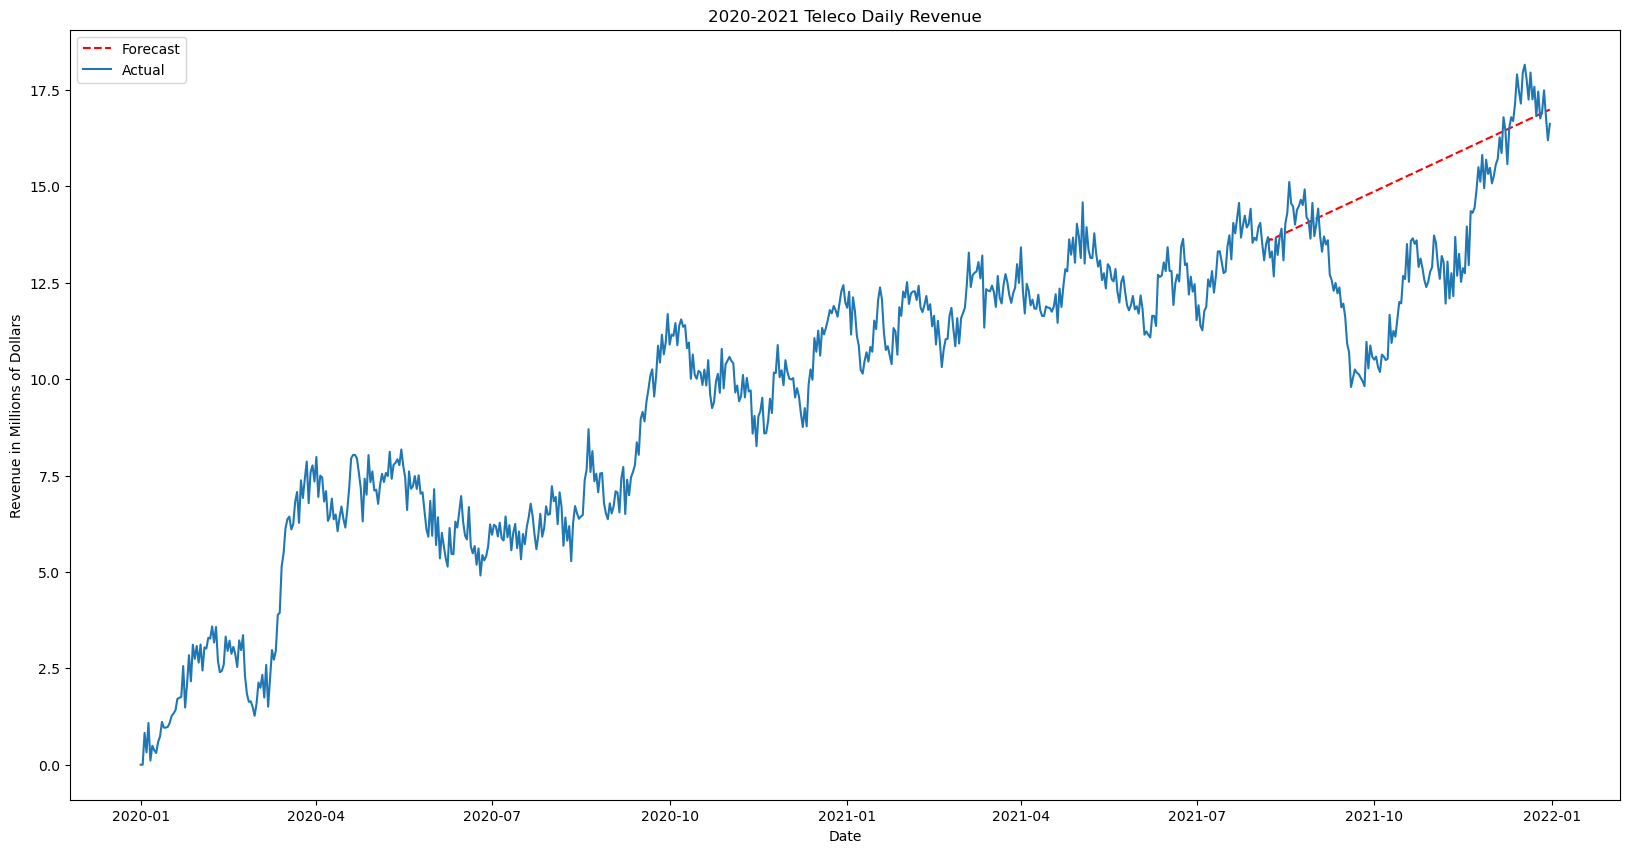

In [23]:
#Plotting actual daily revenue & predicted last 20%
plt.figure(figsize = [20,10])
plt.title("2020-2021 Teleco Daily Revenue")
plt.xlabel('Date')
plt.ylabel('Revenue in Millions of Dollars')
plt.plot(a_forecast, color = 'r',linestyle="--")
plt.plot(times)
plt.legend(['Forecast', 'Actual'])
plt.show()

## D4: Output And Calculations

All the code has been executed from section C1 to D3, below are the final calculations needed to answer the research question. The results of mean absolute percentage error(MAPE) and Mean absolute error (MAE) will be discussed in section E1. 

In [24]:
#Article referenced for MAE & MAPE code(Andres, 2023)
start = times.index.get_loc('2021-08-07')
mae = mean_absolute_error(times['Revenue'].iloc[start:], a_forecast['Revenue'].iloc[start:])
mape = mean_absolute_percentage_error(times['Revenue'].iloc[start:], a_forecast['Revenue'].iloc[start:])*100
print("Mean Absolute Error:", mae)
print("MAPE:", mape, "%")

Mean Absolute Error: 1.9096497141145838
MAPE: 15.948205633308884 %


## D5: Code

All the code needed to implement the time series model is in the included Jupyter ipynb notebook.

## E1: Results

### Selection of an ARIMA model

The selection of the ARIMA model was first identified by the interpretation of the ACF and PACF which led to the conclusion of AR(1). The auto_arima function was also implemented to choose the model with the lowest AIC score, this confirmed ARIMA(1,0,0) as the model selection.

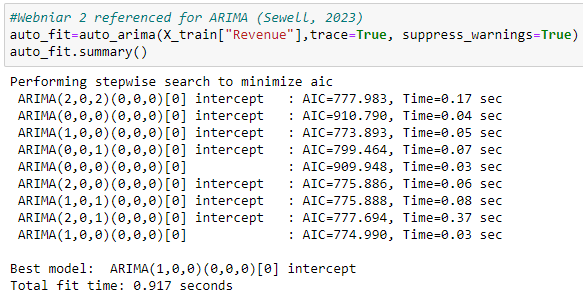

### Prediction interval of the forecast

The prediction interval of the forecast is one day. The prediction interval aligns with the 2-year time series time stamp analyzed and formatted in section C2. The projection confidence interval data below is in daily intervals. 

In [25]:
#Article referenced for confidence_intervals code(Elleh, 2022)
confidence_intervals = projection.conf_int()
confidence_intervals

,lower Revenue,upper Revenue
2021-08-07,-1.075044,0.755043
2021-08-08,-0.899447,1.114725
2021-08-09,-1.040865,1.010091
2021-08-10,-0.988158,1.070487
2021-08-11,-1.014963,1.045302
...,...,...
2021-12-27,-1.006994,1.053705
2021-12-28,-1.006994,1.053705
2021-12-29,-1.006994,1.053705
2021-12-30,-1.006994,1.053705


### Justification of the forecast length

The time series dataset was two years of daily revenue. The dataset was split into 80% training and 20% test, leaving roughly 147 rows of data to project and validate against. This split gives enough historical data to project the remaining 20% and is less than a year of projection.

### Model evaluation procedure and error metric

As previously discussed, the auto_arima function was implemented to choose the model with the lowest AIC score as seen below:

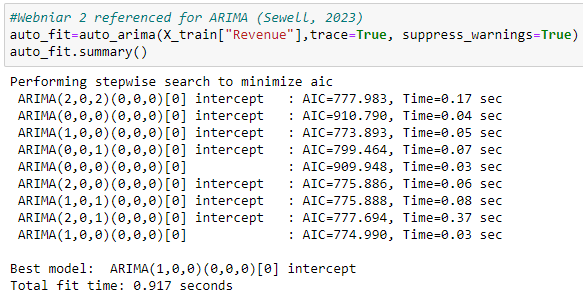

Two error metrics were utilized on the projected forecast, Andres provided two definitions in the article referenced (Andres, 2023):

- Mean Absolute Error (MAE) measures the average size of the error between predicted and actual values in a time series dataset.

- Mean Absolute Percentage Error (MAPE) calculates the average percentage difference between the predicted values and the actual values.

For the projected forecast the mean absolute error was 1.91 and the mean absolute percentage error was 15.95%. 

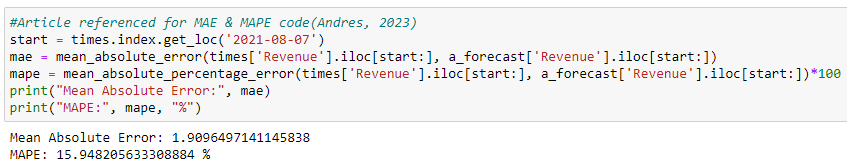
## E2: Annotated Visualization

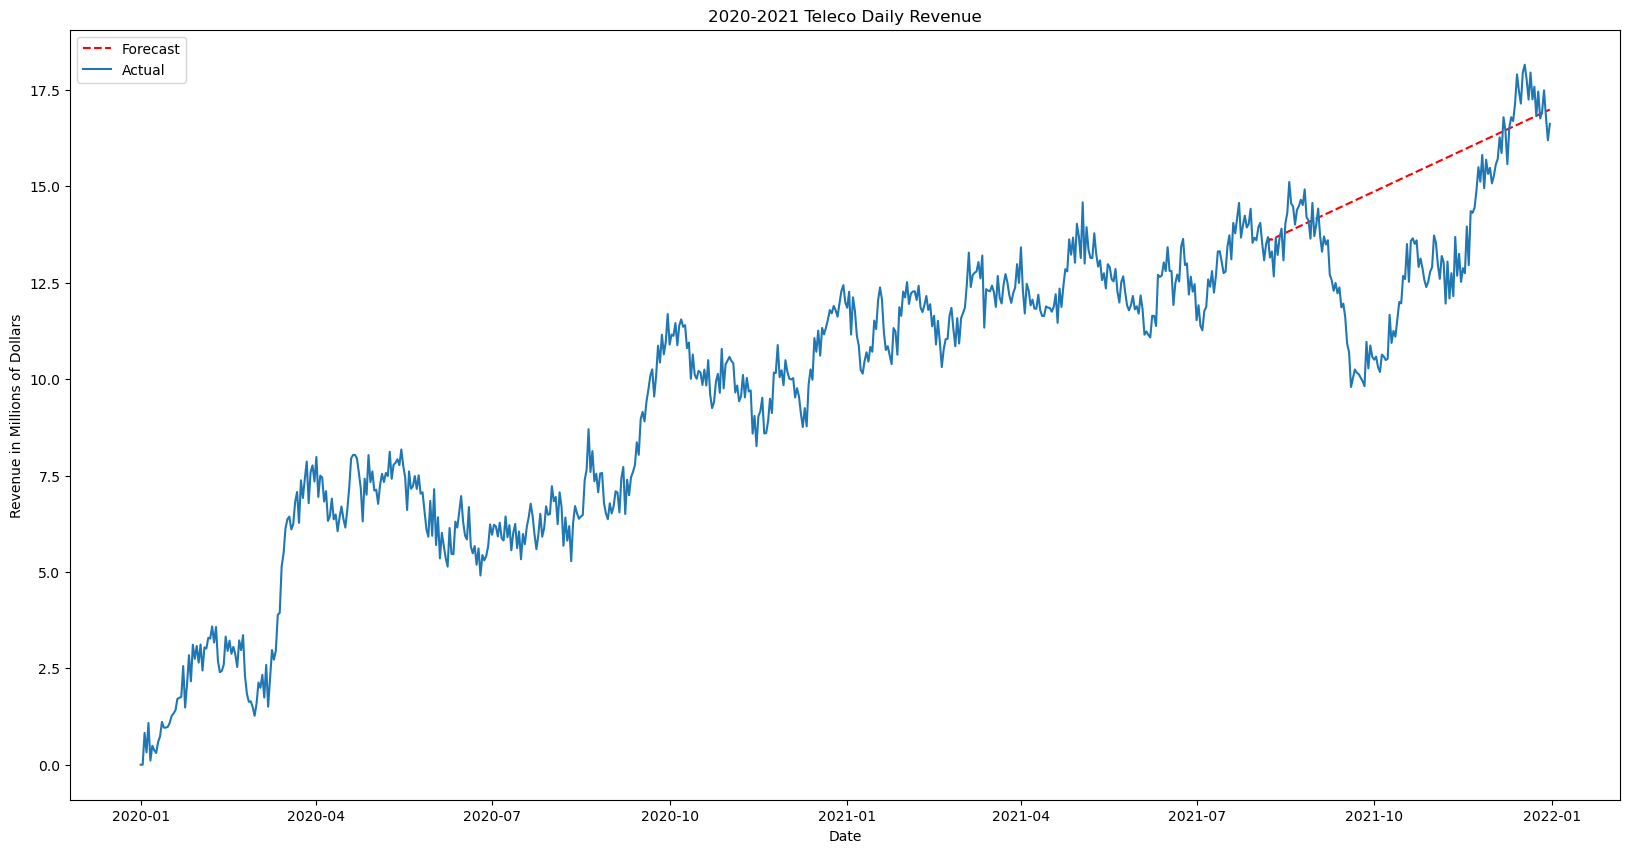

In [26]:
#Plotting actual daily revenue & predicted last 20%
plt.figure(figsize = [20,10])
plt.title("2020-2021 Teleco Daily Revenue")
plt.xlabel('Date')
plt.ylabel('Revenue in Millions of Dollars')
plt.plot(a_forecast, color = 'r',linestyle="--")
plt.plot(times)
plt.legend(['Forecast', 'Actual'])
plt.show()

## E3: Recommendation

To conclude an autoregressive integrated moving average can predict daily revenue with a MAPE of 15.95% or an MAE of 1.91. The MAPE is 5.95% above the goal set at the beginning of the analysis. While this MAPE is outside of the goal range, this forecast can still be useful. The recommendation would be to compare the MAPE to industry standards and discuss with the executive team if the MAPE of 15.95% is significant and acceptable for business use.

## F: Reporting

Included alongside the PDF report is an executed Jupyter ipynb notebook. 

## G: Sources For Third-Party Code

Andres, D. (2023, June 24). Error metrics for time series forecasting - ml pills. ML Pills - Machine Learning Pills. https://mlpills.dev/time-series/error-metrics-for-time-series-forecasting/ 

Bobbitt, Z. (2022, March 31). How to add a trendline in Matplotlib (with example). Statology. https://www.statology.org/matplotlib-trendline/ 

D’Amico, J. (2023, August 16). How to test for stationarity in time series data using Python. Medium. https://medium.com/@JDEconomics/how-to-test-for-stationarity-in-time-series-data-using-python-44d82890aa9d 

Elleh, F. (2022, August). Advanced Data Analytics - Task 1. https://my.wgu.edu/. Retrieved December 5, 2023, from https://srm.file.force.com/servlet/servlet.FileDownload?retURL=https%3A%2F%2Fsrm--c.vf.force.com%2Fapex%2FFDP%2FCommonsExpandedChatter%3Fcode%3DD213&file=00P3x00001mir2aEAA&_CONFIRMATIONTOKEN=VmpFPSxNakF5TXkweE1pMHhPVlF3TmpveE1Ub3pNQzQyTnpOYSxfY2tzUkhoblhkMjZ2a3FEY0hVbVZkSjhLV00zV1BXbXVheHFVZTdyeFFrPSxZVEJoTmpobQ%3D%3D&common.udd.actions.ActionsUtilORIG_URI=%2Fservlet%2Fservlet.FileDownload.

Matplotlib.dates#. matplotlib.dates - Matplotlib 3.8.2 documentation. (n.d.). https://matplotlib.org/stable/api/dates_api.html 

Rishi, R. (2021, June 10). Plotting power spectral density in Matplotlib. Online Tutorials, Courses, and eBooks Library. https://www.tutorialspoint.com/plotting-power-spectral-density-in-matplotlib 

Sewell, W. (2023, December). Advanced Data Analytics - Webinar 2. https://my.wgu.edu/. Retrieved December 5, 2023, from https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=ea04fe77-3e3a-4293-8e9f-af7a00f22a8c. 

Sewell, W. (2023, December). Advanced Data Analytics - Webinar 3. https://my.wgu.edu/. Retrieved December 5, 2023, from https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=ea04fe77-3e3a-4293-8e9f-af7a00f22a8c. 

Tuychiev, B. (2023, February 21). Advanced Time Series Analysis: Decomposition, .... Kaggle. https://www.kaggle.com/code/bextuychiev/advanced-time-series-analysis-decomposition 

YouTube. (2020). #76: Pandas (Part 53): Create Timestamp in Python using pd.to_timedelta() | Tutorial. YouTube. Retrieved December 5, 2023, from https://www.youtube.com/watch?v=RxtYwGjwxW0&amp;ab_channel=learndataa. 

## H: Sources

Ahmed, I. (2023, May 31). What are ACF and PACF plots in time series analysis?. Medium. https://ilyasbinsalih.medium.com/what-are-acf-and-pacf-plots-in-time-series-analysis-cb586b119c5d 

Anais Dotis-Georgiou (2023, October 20). Autocorrelation in time series data: What is autocorrelation?. InfluxData. https://www.influxdata.com/blog/autocorrelation-in-time-series-data/ 

Andres, D. (2023, June 24). Error metrics for time series forecasting - ml pills. ML Pills - Machine Learning Pills. https://mlpills.dev/time-series/error-metrics-for-time-series-forecasting/ 

D’Amico, J. (2023, August 16). How to test for stationarity in time series data using Python. Medium. https://medium.com/@JDEconomics/how-to-test-for-stationarity-in-time-series-data-using-python-44d82890aa9d 

Pandian, S. (2023, November 9). Time series analysis and forecasting: Data-Driven Insights (updated 2023). Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-to-time-series-analysis/ 

Ravelo, C. (2023, March 9). The Stationary Data Assumption in time series analysis. Statistics Solutions. https://www.statisticssolutions.com/stationary-data-assumption-in-time-series-analysis/ 

Sewell, W. (2023, December). Advanced Data Analytics - Webinar 3. https://my.wgu.edu/. Retrieved December 5, 2023, from https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=ea04fe77-3e3a-4293-8e9f-af7a00f22a8c. 
